In [1]:
import os
os.listdir('./data/')

['BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv']

In [2]:
import pandas as pd
colnames = ['0','Date','Price','2','3','4']
df = pd.read_csv('./data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',index_col=['Date'],parse_dates=['Date'], names=colnames, header=0)
df.head()

,0,Price,2,3,4
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [77]:
# bitdf = pd.DataFrame(df['Price'])
# bitnp = bitdf['Price'].to_numpy()
# bitnp[0:2]
bitnp = df['Price'].to_numpy()
bitnp[0:2]

array([123.65499, 125.455  ])

<AxesSubplot:xlabel='Date'>

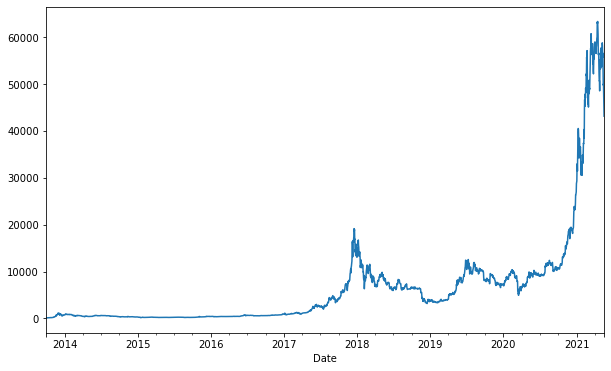

In [4]:
bitdf['Price'].plot(figsize=(10,6))

In [5]:
# convert to numpy and split into train, test
step = bitdf.index.to_numpy()
bitnp, len(bitnp), step, len(step)

(array([  123.65499   ,   125.455     ,   108.58483   , ...,
        47885.62525472, 45604.61575361, 43144.47129086]),
 2787,
 array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', ...,
        '2021-05-16T00:00:00.000000000', '2021-05-17T00:00:00.000000000',
        '2021-05-18T00:00:00.000000000'], dtype='datetime64[ns]'),
 2787)

In [6]:
trainsize = int(0.8*len(bitnp))
trainsize

2229

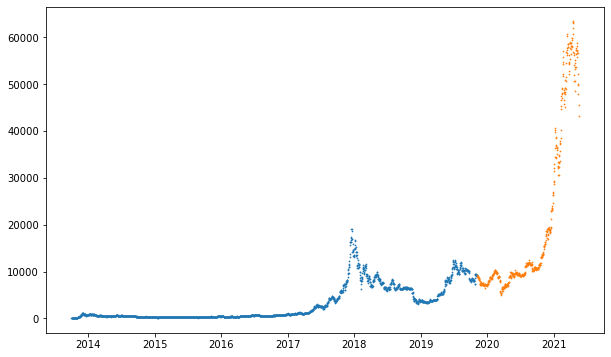

In [7]:
xtrain, xtest = step[:trainsize], step[trainsize:]
ytrain, ytest = bitnp[:trainsize], bitnp[trainsize:]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(xtrain,ytrain,s=.5)
plt.scatter(xtest,ytest,s=.5)

In [8]:
naivefc = ytest[:-1]
len(naivefc), len(ytest), naivefc[5:8]

(557, 558, array([8760.89271814, 8749.52059102, 8656.97092235]))

In [9]:
ytest[0:2]

array([9226.48582088, 8794.35864452])

In [10]:
yactual = ytest[1:]
len(yactual), yactual[5:8]

(557, array([8749.52059102, 8656.97092235, 8500.64355816]))

In [11]:
import tensorflow as tf
mae = tf.keras.metrics.mean_absolute_error(yactual,naivefc)
mse = tf.keras.metrics.mean_squared_error(ytest[1:],naivefc)
rmse = tf.sqrt(mse)
mape = tf.keras.metrics.mean_absolute_percentage_error(ytest[1:],naivefc)
mae, mse, rmse, mape

(<tf.Tensor: shape=(), dtype=float64, numpy=567.9802273457542>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1147547.125023896>,
 <tf.Tensor: shape=(), dtype=float64, numpy=1071.2362601330744>,
 <tf.Tensor: shape=(), dtype=float64, numpy=2.516524929982267>)

### Create Windows, Horizon

In [78]:
import numpy as np
nwindows = 7
nhorizon = 1

def make_windows(x,w=7,h=1):
    #create 1d list of numbers of total size
    d1list = np.arange(w + h)
    # create 2d of this list
    d2list = np.expand_dims(d1list,axis=0)
    # create column of numbers to be added to the 2d list above
    addnum = np.expand_dims(np.arange(len(x)-(w+h-1)), axis=0).T
    # final index is the array where each d2list is added with addnum
    window_indexes = d2list + addnum
    # get values of the input matrix for these indexes
    window_array = x[window_indexes]
    # create windows and lables from this
    windows = window_array[:, :-h]
    labels  = window_array[:,-h:]
    return windows, labels

# take the target data and split into windows and labels
windows, labels = make_windows(bitnp,nwindows,nhorizon)
windows, labels

(array([[  123.65499   ,   125.455     ,   108.58483   , ...,
           121.33866   ,   120.65533   ,   121.795     ],
        [  125.455     ,   108.58483   ,   118.67466   , ...,
           120.65533   ,   121.795     ,   123.033     ],
        [  108.58483   ,   118.67466   ,   121.33866   , ...,
           121.795     ,   123.033     ,   124.049     ],
        ...,
        [58788.20967893, 58102.19142623, 55715.54665129, ...,
         52147.82118698, 49764.1320816 , 50032.69313676],
        [58102.19142623, 55715.54665129, 56573.5554719 , ...,
         49764.1320816 , 50032.69313676, 47885.62525472],
        [55715.54665129, 56573.5554719 , 52147.82118698, ...,
         50032.69313676, 47885.62525472, 45604.61575361]]),
 array([[  123.033     ],
        [  124.049     ],
        [  125.96116   ],
        ...,
        [47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [13]:
len(xtrain), len(windows), len(labels), len(ytrain), len(bitnp)

(2229, 2780, 2780, 2229, 2787)

In [14]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {windows[i]} , Label: {labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] , Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] , Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] , Label: [125.96116]


### Split into train, test sets

In [15]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows, labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [16]:
train_windows[:1], train_labels[:1]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ]]),
 array([[123.033]]))

### Build model

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

tf.random.set_seed(12)
model = tf.keras.Sequential([
    Dense(128, activation='relu'),
    Dense(nhorizon)
])

model.compile(loss = 'mae', optimizer = 'adam')
savepath = './checkpoints/model/' & 'model1'
savebest = tf.keras.callbacks.ModelCheckpoint(filepath=savepath,save_best_only=True, monitor='val_loss')

history = model.fit(train_windows,train_labels, epochs = 100, batch_size=128,
                    callbacks = [savebest],
                    validation_data = (test_windows,test_labels))

Epoch 1/100
18/18 [==============================] - 1s 50ms/step - loss: 1181.9849 - val_loss: 3567.8286
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 331.9626 - val_loss: 1035.9146
Epoch 3/100
18/18 [==============================] - 1s 38ms/step - loss: 201.8118 - val_loss: 1018.2408
Epoch 4/100
18/18 [==============================] - 0s 27ms/step - loss: 182.6059 - val_loss: 1014.8156
Epoch 5/100
18/18 [==============================] - 0s 29ms/step - loss: 177.5322 - val_loss: 987.7560
Epoch 6/100
18/18 [==============================] - 0s 24ms/step - loss: 171.7976 - val_loss: 946.7408
Epoch 7/100
18/18 [==============================] - 0s 28ms/step - loss: 168.9634 - val_loss: 917.6665
Epoch 8/100
18/18 [==============================] - 0s 3ms/step - loss: 164.8548 - val_loss: 995.2873
Epoch 9/100
18/18 [==============================] - 0s 27ms/step - loss: 161.8094 - val_loss: 860.4446
Epoch 10/100
18/18 [==============================] - 0s 3ms

Epoch 48/100
18/18 [==============================] - 0s 2ms/step - loss: 111.9266 - val_loss: 619.5154
Epoch 49/100
18/18 [==============================] - 0s 3ms/step - loss: 112.7609 - val_loss: 703.8804
Epoch 50/100
18/18 [==============================] - 0s 3ms/step - loss: 118.2529 - val_loss: 604.2150
Epoch 51/100
18/18 [==============================] - 0s 27ms/step - loss: 109.4611 - val_loss: 581.1265
Epoch 52/100
18/18 [==============================] - 0s 25ms/step - loss: 109.1242 - val_loss: 578.7573
Epoch 53/100
18/18 [==============================] - 0s 3ms/step - loss: 111.4486 - val_loss: 581.6521
Epoch 54/100
18/18 [==============================] - 0s 3ms/step - loss: 115.6201 - val_loss: 593.5415
Epoch 55/100
18/18 [==============================] - 0s 3ms/step - loss: 120.2033 - val_loss: 579.7883
Epoch 56/100
18/18 [==============================] - 0s 2ms/step - loss: 108.6553 - val_loss: 606.9886
Epoch 57/100
18/18 [==============================] - 0s 3ms/s

In [33]:
savepath = './checkpoints/model/' + model
savepath

TypeError: can only concatenate str (not "Sequential") to str

<AxesSubplot:>

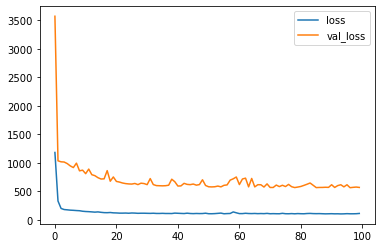

In [19]:
pd.DataFrame(history.history).plot()

In [21]:
model.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 569.8884


569.8883666992188

In [22]:
ypreds = model.predict(test_windows)
ypreds

array([[ 8898.318 ],
       [ 8813.025 ],
       [ 9082.744 ],
       [ 8842.459 ],
       [ 8775.14  ],
       [ 8786.7   ],
       [ 8722.905 ],
       [ 8565.374 ],
       [ 8502.119 ],
       [ 8570.261 ],
       [ 8307.005 ],
       [ 8150.9272],
       [ 8110.9126],
       [ 7724.531 ],
       [ 7322.275 ],
       [ 7301.6255],
       [ 7124.8574],
       [ 7211.634 ],
       [ 7193.1484],
       [ 7502.3877],
       [ 7474.4966],
       [ 7711.364 ],
       [ 7629.2   ],
       [ 7436.9043],
       [ 7364.414 ],
       [ 7352.797 ],
       [ 7272.5264],
       [ 7400.966 ],
       [ 7545.2505],
       [ 7580.618 ],
       [ 7586.9087],
       [ 7403.1543],
       [ 7278.365 ],
       [ 7234.1416],
       [ 7229.4316],
       [ 7270.824 ],
       [ 7149.377 ],
       [ 7135.0337],
       [ 6953.5747],
       [ 6650.541 ],
       [ 7311.2017],
       [ 7287.576 ],
       [ 7174.4224],
       [ 7281.614 ],
       [ 7293.9336],
       [ 7223.3755],
       [ 7251.773 ],
       [ 7259

In [23]:
ypreds[0:2], test_labels[0:2]

(array([[8898.318],
        [8813.025]], dtype=float32),
 array([[8798.04205463],
        [9081.18687849]]))

In [24]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.squeeze(tf.cast(y_true, dtype=tf.float32))
  y_pred = tf.squeeze(tf.cast(y_pred, dtype=tf.float32))

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  #mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()} #,"mase": mase.numpy()}

In [25]:
evaluate_preds(y_true=test_labels, y_pred=ypreds)

{'mae': 569.88837, 'mse': 1171336.0, 'rmse': 1082.2827, 'mape': 2.5473719}

In [26]:
model.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 569.8884


569.8883666992188

In [27]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("./checkpoints/model")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 565.3145


565.314453125

In [49]:
nhorizon=3
nwindows=9
# take the target data and split into windows and labels
windows, labels = make_windows(bitnp,nwindows,nhorizon)
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {windows[i]} , Label: {labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795
 123.033   124.049  ] , Label: [125.96116 125.27966 125.9275 ]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033
 124.049   125.96116] , Label: [125.27966 125.9275  126.38333]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049
 125.96116 125.27966] , Label: [125.9275  126.38333 135.24199]


In [68]:
# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
    Dense(64, activation="relu"),
    Dense(128, activation="relu"),
    Dense(nhorizon)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())
savepath = './checkpoints/' + 'model3'
savebest = tf.keras.callbacks.ModelCheckpoint(filepath=savepath,save_best_only=True, monitor='val_loss',verbose=0)
history3 = model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[savebest])

INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3\assets
INFO:tensorflow:Assets written to: ./checkpoints\model3

In [69]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 600.0480


600.0479736328125

In [75]:
model_3.predict(test_windows[-1:]), test_labels[-3:]

(array([[47057.934, 46509.562, 45899.637]], dtype=float32),
 array([[47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [66]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model(savepath)
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 582.7297


582.729736328125

In [53]:
model.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 569.8884


569.8883666992188

<AxesSubplot:>

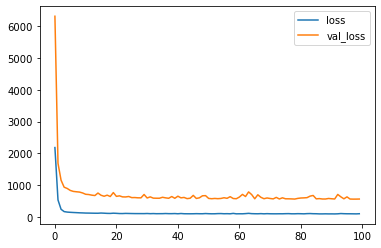

In [63]:
pd.DataFrame(history3.history).plot()

<AxesSubplot:>

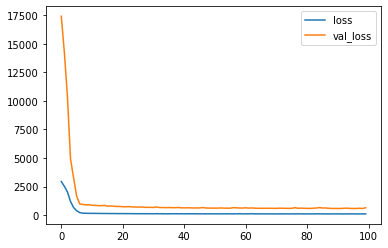

In [67]:
pd.DataFrame(history3.history).plot()